## Defining The Model

In [1]:
from typing import List
from model_trainer.custom_models import PerceptronBD
from torch import nn
import torch

class CustomSiam(nn.Module):
    def __init__(self, encoder_nodes: List[int], projector_nodes: List[int]):
        """
        Experimmental Implementation of SamSiam. Make sure the projector nodes has the same in/out nodes as 
        encoder_nodes[-1]. Otherwise the model will not work.
        Example:
        -------
        model = CustomSiam([20, 10, 5], [5, 5])
        
        Args:
            encoder_nodes (List[int]): List of nodes for the encoder. The last node should be the output dimension
            projector_nodes (List[int]): List of nodes for the projector. The last node should be the output dimension
            TODO: At some point, take out the customization for projector_nodes and just have layer count as the only
            input param. for the projector.
        
        
        """
        super(CustomSiam, self).__init__()
        
        self.input_dim = encoder_nodes[0]
        
        # We need to make an encoder that ends in BatchNorm and not a Linear layer
        dummy_encoder_nodes = encoder_nodes + [1]       # Add a dummy Linear layer to the encoder - remove later
        self.encoder = PerceptronBD(dummy_encoder_nodes)
        self.encoder.layers = self.encoder.layers[:-2]  # Remove the last flatten and dummy Linear layer
        self.encoder.layers.append(nn.BatchNorm1d(encoder_nodes[-1], affine=False))  # Add a BatchNorm layer
        # self.encoder.layers[-1].bias.requires_grad = False  # Turn off the bias for the BatchNorm layer(SamSiam github)
        self.encoder.model = nn.Sequential(*self.encoder.layers)    # Reassign the model to the new layers 
        
        self.projector = PerceptronBD(projector_nodes)
    
    def forward(self, x):
        # Split x into two parts
        x1, x2 = x.chunk(2, dim=1)
        z1 = self.encoder(x1)
        z2 = self.encoder(x2)
        p1 = self.projector(z1)
        p2 = self.projector(z2)
        
        return torch.cat([p1, p2, z1.detach(), z2.detach()], dim=1)    

## Defining The Custom Similarity Loss

In [2]:
# Define a Custom Loss
from model_trainer.core import LossFunction
from model_trainer.loss_funcs import TorchLossWrapper
from model_trainer.visualizations import LossVisualizerMixin


class NegCosSimLoss(LossFunction, LossVisualizerMixin):
    def __call__(self, model_output, dataloader_data, trainer_mode):
        p1, p2, z1, z2 = model_output.chunk(4, dim=1)
        z1 = z1.detach()  # Stop the gradient from flowing back to the encoder
        z2 = z2.detach()  # Stop the gradient from flowing back to the encoder

        # Normalize the projections and the encodings
        p1 = self._l2_normalize(p1)
        p2 = self._l2_normalize(p2)
        z1 = self._l2_normalize(z1)
        z2 = self._l2_normalize(z2)

        # Calculate the negative cosine similarity loss
        dot_product_p1_z1 = torch.sum(p1 * z1, dim=1)
        dot_product_p2_z2 = torch.sum(p2 * z2, dim=1)
        loss = (- dot_product_p1_z1.mean() / 2 - dot_product_p2_z2.mean() / 2)
        
        self.loss_tracker_step_update(loss.item(), trainer_mode)
        return loss

    def __str__(self):
        return f"Negative Cosine Similarity Loss"

    @staticmethod
    def _l2_normalize(x: torch.Tensor) -> torch.Tensor:
        return x / x.norm(p=2, dim=1, keepdim=True)

## Testing/Debugging Model with Dummy Data (Comment Out)

In [3]:
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

# model = CustomSiam([20, 10, 5], [5, 5])

# # Write a training loop to minimize the negative cosine similarity loss
# optimizer = optim.Adam(model.parameters(), lr=1e-2)
# fake_data = torch.randn(100, 20)
# dataset = TensorDataset(fake_data, fake_data + 0.1)
# criteria = NegCosSimLoss()
# dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# for epcoh in range(200):
#     epoch_loss = 0.
#     for x1, x2 in dataloader:
#         optimizer.zero_grad()
#         x = torch.cat([x1, x2], dim=1)
#         x = model(x)
#         loss = criteria(x)
#         loss.backward()
#         # print("batch loss:", loss.item())
#         optimizer.step()
#         epoch_loss += loss.item()
#     print("epoch loss:", epoch_loss)


In [4]:
# import torch.nn.functional as F

# test_input = torch.cat([fake_data[0, :].unsqueeze(0), fake_data[0, :].unsqueeze(0) + 0.1], dim=1)
# model = model.eval()
# p1, p2, z1, z2 = torch.chunk(model(test_input), 4, dim=1)

# # Print the vectors
# print("p1:", p1)
# print("p2:", p2)
# print("z1:", z1)
# print("z2:", z2)

# # Print the negative cosine similarity between the two projections
# print("neg_cosine_similarity_loss(p1, z2):", F.cosine_similarity(p1, z2))
# print("neg_cosine_similarity_loss(p2, z1):", F.cosine_similarity(p2, z1))

## Test With TFO Simulation Data 

In [5]:
from pathlib import Path
import json
from torch.optim.adam import Adam
from torch.optim.sgd import SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from model_trainer import RandomSplit, ValidationMethod, HoldOneOut, CVSplit, CombineMethods
from inverse_modelling_tfo.model_training.custom_models import (
    PerceptronBD,
    CNN2FC,
    FeatureResidualNetwork,
    CNN2FC2dInput,
    SplitChannelCNN
)

from inverse_modelling_tfo.visualization import generate_model_error_and_prediction
import torchinfo
from inverse_modelling_tfo.misc.misc_training import set_seed

# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [6]:
# file_name = 'logI2_by_I1'
# file_name = 'I1_and_I2'
# file_name = 'pulsation_ratio'
# file_name = "pulsation_ratio_interp_sd"
file_name = "wide_intensity"
# Load data
DATA_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name}.pkl"
data = pd.read_pickle(DATA_PATH)

# Load Configs
CONFIG_PATH = DATA_PATH.with_suffix(".json")
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)
labels = config["labels"]
features = config["features"]

In [7]:
y_columns = ["Maternal Wall Thickness"]  # The column that changes between two augmentations

x_columns = features  # What to use as input
# x_columns = [features[i] for i in [3, 8, 12, 15, 19, 23, 28, 35, 39]] # Certain specific detectors

print("X Columns", x_columns)
print("Y Columns", y_columns)

X Columns ['10_2.0', '15_2.0', '19_2.0', '24_2.0', '28_2.0', '33_2.0', '37_2.0', '41_2.0', '46_2.0', '50_2.0', '55_2.0', '59_2.0', '64_2.0', '68_2.0', '72_2.0', '77_2.0', '81_2.0', '86_2.0', '90_2.0', '94_2.0', '10_1.0', '15_1.0', '19_1.0', '24_1.0', '28_1.0', '33_1.0', '37_1.0', '41_1.0', '46_1.0', '50_1.0', '55_1.0', '59_1.0', '64_1.0', '68_1.0', '72_1.0', '77_1.0', '81_1.0', '86_1.0', '90_1.0', '94_1.0']
Y Columns ['Maternal Wall Thickness']


In [8]:
# Normalize
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

In [9]:
IN_FEATURES = len(x_columns)    # The model takes 2 inputs of this size
OUT_FEATURES = 20                # Feature Vector size

# These attributes stay constant between 2 points picked for change detection
change_detection_fixed_columns = [
    "Maternal Hb Concentration",
    "Maternal Saturation",
    # "Fetal Hb Concentration 2",
    "Fetal Hb Concentration",
    "Fetal Saturation",
]
print("In Features :", len(x_columns))
print("Out Features:", OUT_FEATURES)

In Features : 40
Out Features: 20


In [10]:
from inverse_modelling_tfo.model_training.DataLoaderGenerators import ChangeDetectionDataLoaderGenerator, RowCombinationDataLoaderGenerator
from model_trainer import ModelTrainer, TorchLossWrapper, DataLoaderGenerator, SumLoss, TorchLossWrapper
from model_trainer.ModelTrainer import ModelTrainerNoisy


set_seed(40)

## Validation Methods
validation_method = RandomSplit(0.8)

## Define The DataLoader
dataloader_gen = RowCombinationDataLoaderGenerator(data, x_columns, change_detection_fixed_columns, 128, {'shuffle': True})

## Define The Loss Function
criterion = NegCosSimLoss(name="NegCosSim")

## Defining The Model
model = CustomSiam([IN_FEATURES, 30, 20, OUT_FEATURES], [OUT_FEATURES, OUT_FEATURES // 2, OUT_FEATURES])


# Putting it all together
trainer = ModelTrainer(model, dataloader_gen, validation_method, criterion)

In [11]:
trainer.set_optimizer(Adam, {'lr': 1e-4, 'weight_decay': 1e-4})
# trainer.set_batch_size(32)
trainer.run(100)

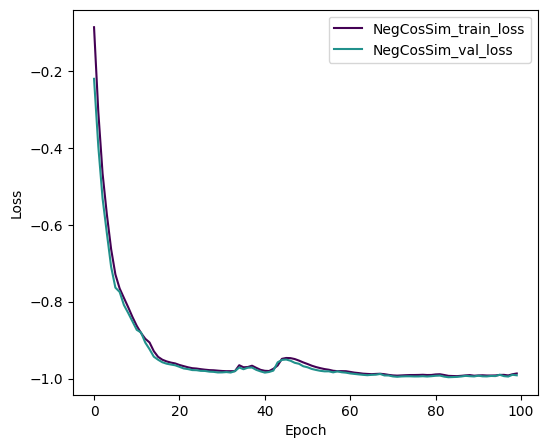

In [12]:
loss_curves = criterion.plot_losses(pin_bottom_to_zero=False)
plt.show()

In [13]:
criterion.print_table()

                   Losses                   
┏━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃    👀     ┃ Train Loss ┃ Validation Loss ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ NegCosSim │  -0.9868   │     -0.9916     │
└───────────┴────────────┴─────────────────┘

<console width=115 ColorSystem.TRUECOLOR>